![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico: Aprendizado de Máquina

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando diversos modelos baseados em algoritmos bem conhecidos de Aprendizado de Máquina. Provavelmente essas abordagens não funcionarão bem se aplicadas diretamente como fazemos aqui. O objetovo, neste estudo, é apenas demonstrar as limitações de abordagens puramente de aprendizado, sem suposições *a priori* sobre a dinâmica do processo sendo aprendido. Serve, portanto, como *baseline* para outros estudos.


**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [418]:
import os
import math
import pandas as pd
import numpy as np
import hyperopt
from hyperopt import hp

from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [14]:
plt.style.use('fivethirtyeight')

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [15]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Leitura de Dados

Supomos que já existem dados temporais em forma de janela deslizante para consumo aqui. Esses dados devem ter sido gerados em fase de pré-processamento (ver *notebook* `data_preprocessing.ipynb`).

In [527]:
df_input_data = pd.read_csv(f'../data/preprocessed/covid19_sliding_window.csv', index_col=[0], parse_dates=True)
locations = df_input_data['location'].unique()

print("Unique locations:", len(locations))
#print(locations)
df_input_data.head()

Unique locations: 113


,location,population,relative_day,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,target
0,Afghanistan,38928341.0,9,33,0,16,15,8,27,25,26,43,0,35
1,Afghanistan,38928341.0,10,0,16,15,8,27,25,26,43,0,35,29
2,Afghanistan,38928341.0,11,16,15,8,27,25,26,43,0,35,29,38
3,Afghanistan,38928341.0,12,15,8,27,25,26,43,0,35,29,38,30
4,Afghanistan,38928341.0,13,8,27,25,26,43,0,35,29,38,30,56


Se quisermos, alternativamente, definir manualmente os países a serem considerados, podemos fazer isso agora.

In [419]:
locations = ['Argentina', 'Australia', 'Austria',  'Brazil', 'Canada', 'Chile', 'China', 'Denmark', 'France', 'Italy', 'Spain', 'Sweden', 'Switzerland',
             'United Kingdom', 'United States']

Precisamos agora separar os dados obtidos em treino e teste. Existem alguns modos como isso poderia ser feito. Aqui optamos por manter as localidades íntegras, de modo que cada uma esteja apenas em treino ou teste. Isso é importante porque espera-se que a epidemia siga um ciclo bem definido em cada localidade, então é importante capturar todas as etapas desse ciclo para cada uma.

In [420]:
test_locations = ['Brazil', 'United States', 'Italy']

In [421]:
train_locations = [l for l in locations if l not  in test_locations]
len(train_locations)

12

In [422]:
df_train = df_input_data[df_input_data['location'].isin(train_locations)]
df_X_train = df_train.iloc[:, :-1].drop('location', axis=1)
df_y_train = df_train.iloc[:, -1]

df_test = df_input_data[df_input_data['location'].isin(test_locations)]
df_X_test = df_test.iloc[:, :-1].drop('location', axis=1)
df_y_test = df_test.iloc[:, -1]

In [423]:
df_X_train.head()

,population,relative_day,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
77,45195777.0,9,11,9,14,18,31,30,67,41,35,86
78,45195777.0,10,9,14,18,31,30,67,41,35,86,115
79,45195777.0,11,14,18,31,30,67,41,35,86,115,87
80,45195777.0,12,18,31,30,67,41,35,86,115,87,101
81,45195777.0,13,31,30,67,41,35,86,115,87,101,55


In [424]:
df_y_train.head()

77    115
78     87
79    101
80     55
81     75
Name: target, dtype: int64

## Funções Auxiliares

In [425]:
def plot_simulation_versus_actual(estimator, df, location, window_size=10):
    df = df[df['location'] == location]
    df = df.drop('location', axis=1)
    
    values_to_plot = []
    
    X_sim = list(df.iloc[0, :-1].values)
    print(X_sim[:-1])
    
    for t in range(0, len(df)):
        X = list(df.iloc[t, :-1].values)
        y = df.iloc[t, -1]
        y_pred = estimator.predict([X_sim])[0]
        
        values_to_plot.append([y, y_pred])
        
        # Note that: (i) we KEEP the X values that are not simulated, because they may contain known contextual information that change over time; 
        #            (ii) the rest is from the simulated values (past or predicted).
        X_sim = X[:-window_size] + X_sim[-window_size + 1:] + [y_pred]
        #print('After:', X_sim)
            
    df_results = pd.DataFrame(values_to_plot, columns=['y', 'y_pred'])
    ax = sns.lineplot(data=df_results)
    ax.set_title('Real vs. Previsto')
    
    plt.figure()
    df_results_cumsum = df_results.cumsum()
    ax = sns.lineplot(data=df_results_cumsum)
    ax.set_title('Real vs. Previsto (cumulativo)')
    
    #return df_results

## Modelos Clássicos

Abaixo faremos uma série de experimentos com modelos de Aprendizado de Máquina clássicos.

Faremos a otimização de hiperparâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir o espaço de busca de parâmetros e uma função objetivo a ser otimizada.

In [519]:
space = hp.choice('model_type', [
        {
            'type': 'lasso',
            'alpha': hp.lognormal('lasso_alpha', 0, 4)
        },
        {
            'type': 'knn',
            'n_neighbors': hp.uniform('knn_n_neighbors', 5, 100)

        },
        {
            'type': 'rf',
            'n_estimators': hp.uniform('rf_n_estimators', 10, 300),
            'criterion': hp.choice('rf_criterion', ['mse', 'mae']),
            'max_depth': hp.choice('rf_max_depth',
                [None, hp.uniform('rf_max_depth_int', 3, 50)]),
            'min_samples_split': hp.uniform('rf_min_samples_split', 2, 50),
            'min_samples_leaf': hp.uniform('rf_min_samples_leaf', 2, 50)
        },
        {
            'type': 'xgboost',
            'n_estimators': hp.uniform('xgboost_n_estimators', 10, 300),
            'max_depth': hp.uniform('xgboost_max_depth_int', 3, 50),
            'min_child_weight': hp.uniform('xgboost_min_child_weight', 1, 50),
            'learning_rate': hp.uniform('xgboost_learning_rate', 0.001, 1.0),
            'gamma': hp.lognormal('xgboost_gamma', 0.0, 3.0)
        }
        #{
        #    'type': 'mlp',
        #    'hidden_layer_sizes': hp.choice('mlp_hidden_layer_sizes',
        #                                   [(100,), (100,100), (100, 100, 100), (100, 50), (100, 50, 25)]),
        #    'solver': hp.choice('mlp_solver', ['lbfgs', 'sgd', 'adam']),
        #    'learning_rate_init': hp.normal('mlp_learning_rate_init', 0.0001, 0.0001)
        #}
    ])

In [520]:
def optm_objective(args):
    try:
        #print(args)
        model_type = args['type']

        # pick the estimator to build according to what was specified in the arguments
        if model_type == 'lasso':
            est = linear_model.Lasso(alpha=args['alpha'])

        elif model_type == 'knn':
            est = KNeighborsRegressor(n_neighbors = int(args['n_neighbors']), 
                                      n_jobs=-1)

        elif model_type == 'rf':
            est = RandomForestRegressor(n_estimators = int(args['n_estimators']), 
                                        criterion = args['criterion'],
                                        max_depth = None if args['max_depth'] is None else int(args['max_depth']), 
                                        min_samples_split = int(args['min_samples_split']),
                                        min_samples_leaf = int(args['min_samples_leaf']),
                                        n_jobs=-1)

        elif model_type == 'xgboost':
            est = XGBRegressor(n_estimators = int(args['n_estimators']), 
                               max_depth = args['max_depth'],
                               learning_rate = args['learning_rate'],
                               gamma= args['gamma'],
                               min_child_weight = args['min_child_weight'],
                               n_jobs=-1)
            
        elif model_type == 'mlp':
            est = MLPRegressor(hidden_layer_sizes=args['hidden_layer_sizes'], 
                               solver=args['solver'],
                               learning_rate_init=args['learning_rate_init'])

        else:
            raise Exception(f'Undefined model type: {model_type}.')

        # define a pipeline with preprocessing steps
        est = Pipeline([('scale', StandardScaler()),
                        ('est', est)])

        # Score
        scores = cross_val_score(est, df_X_train, df_y_train, cv=2, scoring='neg_mean_absolute_error')
        score = -1*np.mean(scores)

        # Fit for later use
        est.fit(df_X_train, df_y_train)

        # return the loss and other meta-data about the execution
        return {'loss': score,
                'status': hyperopt.STATUS_OK, 
                'attachments': {
                    'estimator': est
                }}
    
    except Exception as e:
        return {'status': hyperopt.STATUS_FAIL}

In [521]:
trials = hyperopt.Trials()
best = hyperopt.fmin(optm_objective, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)
best

[21:00:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

{'model_type': 2,
 'rf_criterion': 0,
 'rf_max_depth': 0,
 'rf_min_samples_leaf': 5.077459212604607,
 'rf_min_samples_split': 9.897683016675774,
 'rf_n_estimators': 10.366213017010132}

Vamos localizar o estimador com menor erro para poder usá-lo em seguida.

In [522]:
min_loss = None
best_i = None
for i, result in enumerate(trials.results):
    if result['status'] == 'ok':
        if (min_loss is None) or (result['loss'] < min_loss):
            min_loss = result['loss']
            best_i = i

print(best_i, min_loss)
best_estimator = trials.trial_attachments(trials.trials[best_i])['estimator']
best_estimator

861 430.26932427856593


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('est',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=5, min_samples_split=9,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=-1,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

Qual o erro no conjunto de teste?

In [523]:
y_pred = best_estimator.predict(df_X_test)
mean_absolute_error(df_y_test, y_pred)

5105.685970341157

Finalmente, vejamos graficamente como o modelo se comporta em alguns cenários específicos de teste.

[212559409.0, 9.0, 57.0, 137.0, 193.0, 283.0, 224.0, 418.0, 345.0, 310.0, 232.0]


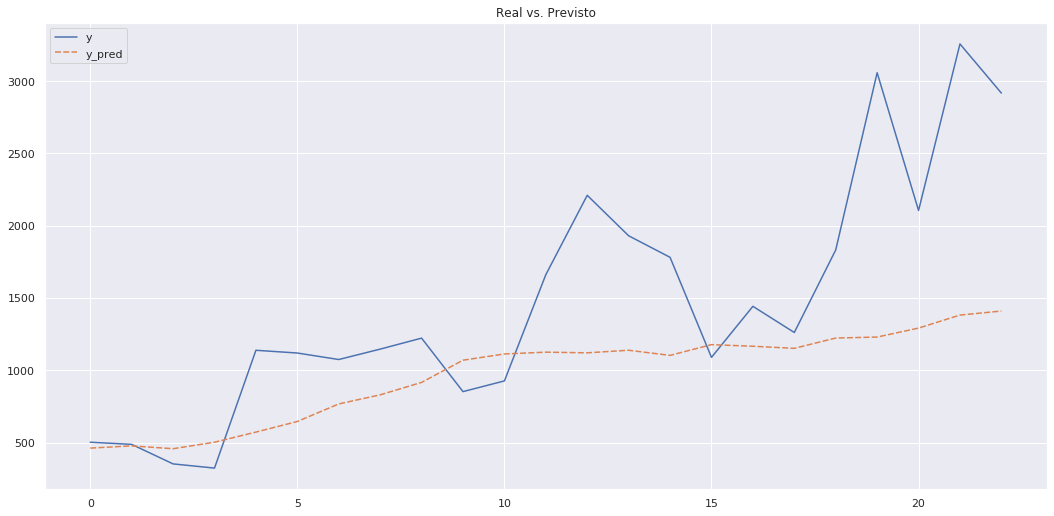

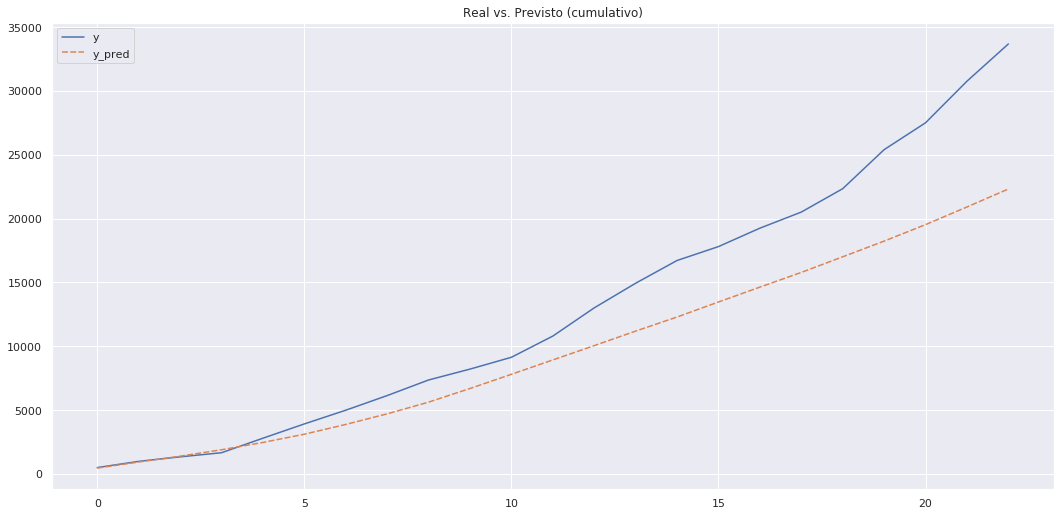

In [524]:
plot_simulation_versus_actual(est, df_test, 'Brazil')

[60461828.0, 9.0, 62.0, 53.0, 97.0, 93.0, 78.0, 250.0, 238.0, 240.0, 561.0]


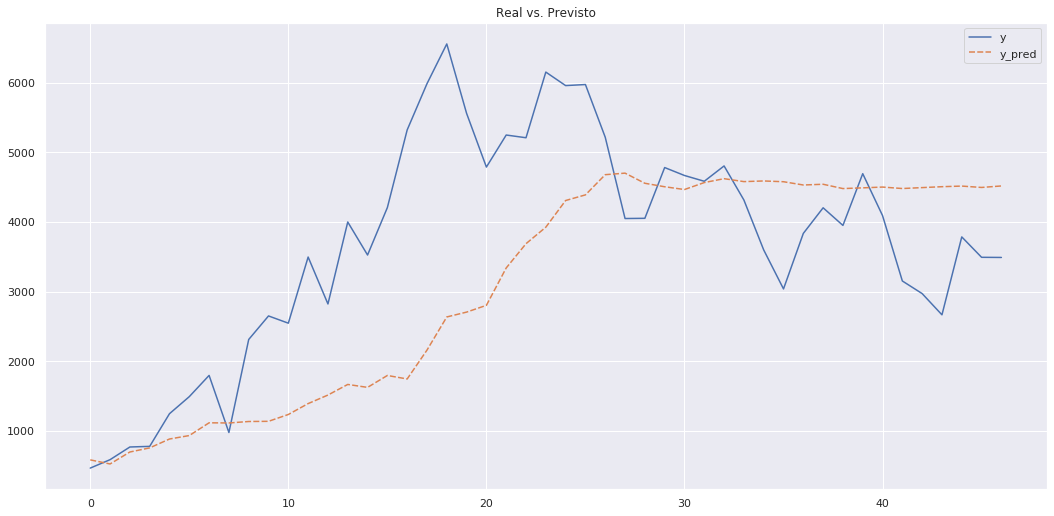

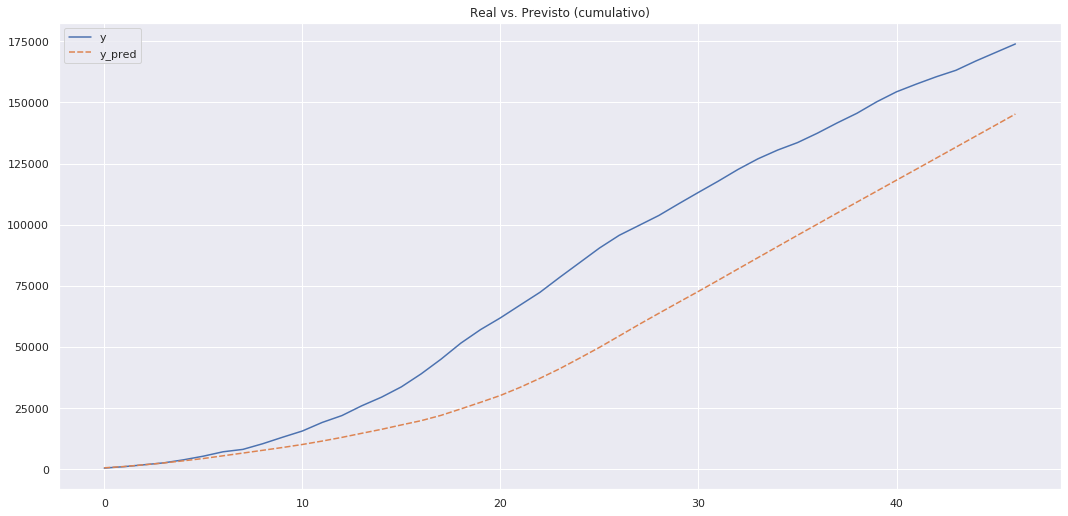

In [525]:
plot_simulation_versus_actual(est, df_test, 'Italy')

[331002647.0, 9.0, 3.0, 20.0, 14.0, 22.0, 34.0, 74.0, 105.0, 95.0, 121.0]


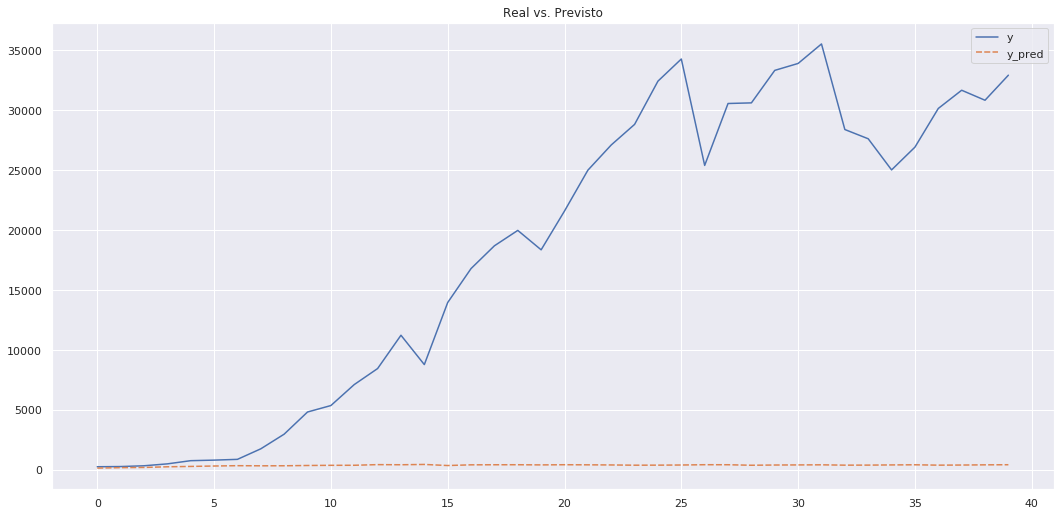

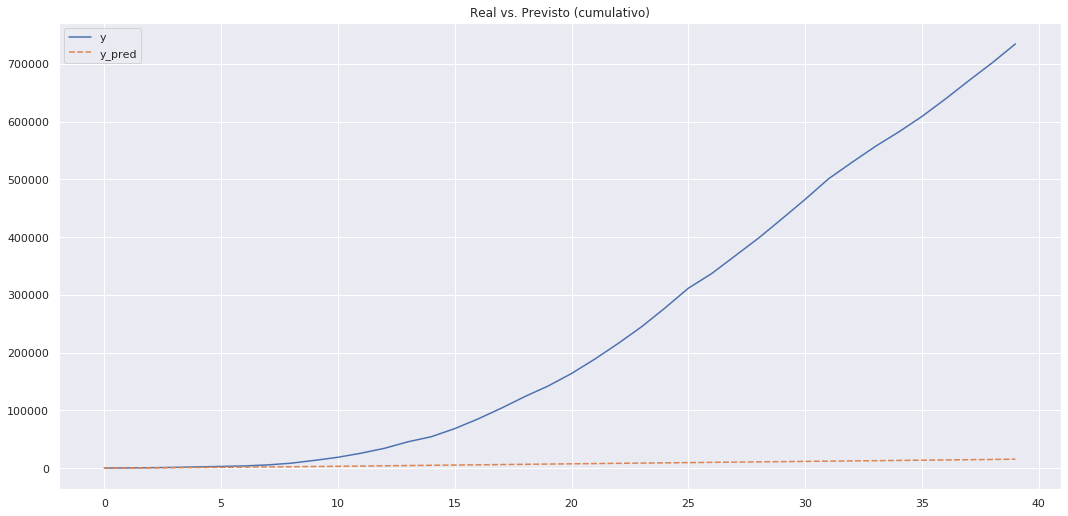

In [526]:
plot_simulation_versus_actual(est, df_test, 'United States')

## Conclusão

Vemos que, em relação a modelos epidemiológicos clássicos, que incorporam informação de domínio *a priori*, os modelos puros de Aprendizado de Máquina deixam bastantea desejar, ao menos do modo usual de se empregá-los.